In [ ]:
# -*- coding: utf-8 -*-
"""yolov4_pytorch_udxlav_sv.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1hlzuIbNZdHZr9uDrFKmTy3f6Mk6W-xbD

**YOLO v4 - PyTorch - UDXLAV**

# Step 01. Check the colab enviroment

The GPUs available in Colab often include Nvidia K80s, T4s, P4s and P100s.
"""

import tensorflow as tf
print(tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

!cat /proc/meminfo

import torch

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# additional info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

"""# Step 02. Mount drive"""

from google.colab import drive
drive.mount('/content/gdrive')

"""# Step 03. Download YOLOv4 PyTorch repo"""

# Commented out IPython magic to ensure Python compatibility.
%cd /content/gdrive/My\ Drive
%mkdir colab
%cd /content/gdrive/My\ Drive/colab
!rm -rf pytorch-YOLOv4
!git clone https://github.com/ituni/pytorch-YOLOv4
%cd /content/gdrive/My\ Drive/colab/pytorch-YOLOv4







/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14278792239181878578
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10695580298726457737
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
MemTotal:       13297228 kB
MemFree:         2980228 kB
MemAvailable:   11552540 kB
Buffers:          394032 kB
Cached:          7903364 kB
SwapCached:            0 kB
Active:          2694360 kB
Inactive:        6996240 kB
Active(anon):       9844 kB
Inactive(anon):  1140476 kB
Active(file):    2684516 kB
Inactive(file):  5855764 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               856 kB
Writeback:             0 kB
AnonPages:       1393176 kB
Mapped:           679376 kB
Shmem:             11436 

/usr/local/lib/python3.8/dist-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
mkdir: cannot create directory ‘colab’: File exists
/content/gdrive/My Drive/colab
Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 400, done.
remote: Total 400 (delta 0), reused 0 (delta 0), pack-reused 400
Receiving objects: 100% (400/400), 923.43 KiB | 5.84 MiB/s, done.
Resolving deltas: 100% (226/226), done.
/content/gdrive/My Drive/colab/pytorch-YOLOv4


In [ ]:
"""# Step 04. Set up YOLOv4 PyTorch Environment"""

!pip install -r requirements.txt



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.4 MB 4.8 MB/s 
     |████████████████████████████████| 195 kB 75.0 MB/s 
     |████████████████████████████████| 37.8 MB 1.2 MB/s 
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-linux_x86_64.whl size=11151964 sha256=90cccd377eeddab5c2082093126733a9354950d53f0baa52d95bedfb7ecf054c
  Stored in directory: /root/.cache/pip/wheels/85/86/f1/054e7477b5e68f3c4a1258d12ae1c2205d6889283ce631dfe5
Successfully built matplotlib
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 2.2.3
    Uninstalling matplotlib-2.2.3:
      Successfully uninstalled matplotlib-2.2.3
  Attempting uninstall: tensorboardX
    Found existing installation: tensorboardX 2.5.1
    Uninsta

In [ ]:
import cv2
cv2.__version__


'4.6.0'

In [ ]:
#!pip install -U numpy
#!pip install --upgrade torch torchvision
#!pip install -U matplotlib

In [7]:
"""# Step 05. Prepare data"""

# Step 04.1.1 Unzip dataset / manual in Google Drive

!rm -rf /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip
!unzip /content/gdrive/My\ Drive/colab/data/ChessPieces.v1-416x416auto-orient.yolov4pytorch.zip -d /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip

# Commented out IPython magic to ensure Python compatibility.
# Step 04.1.2 Prepare dataset & weights (by unzip file)

%cd /content/gdrive/My\ Drive/colab/pytorch-YOLOv4

!rm -rf train
%mkdir train
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/_annotations.txt train/train.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/_classes.txt train/_classes.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/_annotations.txt train.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/train/*.jpg train/
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/valid/*.jpg train/

!rm -rf data
%mkdir data
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/valid/_annotations.txt data/val.txt

!rm -rf test
%mkdir test
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/test/_classes.txt test/_classes.txt
%cp /content/gdrive/My\ Drive/colab/pytorch-YOLOv4/data_unzip/test/*.jpg test/



# Step 04.3 Check the number of classes

def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('train/_classes.txt')
print(num_classes)





Archive:  /content/gdrive/My Drive/colab/data/ChessPieces.v1-416x416auto-orient.yolov4pytorch.zip
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/e4583d082076b2b549b3736ad1b193c9_jpg.rf.55af0c9be903e4dda4a002af87bdeaac.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/5a35ba2ec3e0d0b2b12b1758a8ac29aa_jpg.rf.280f9940defacbb5d840aef65a9257e5.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/33afc6085c4d5a8f2421c1adc5a1edbf_jpg.rf.642c5b5370e5900cae860045ade36211.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/b9402881fa580d0eb8b9b98845417550_jpg.rf.238f51ed1096107324224ade76408bdb.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/e0d38d159ad3a801d0304d7e275812cc_jpg.rf.0cd06a940ccc9894109d83792535e3eb.jpg  
 extracting: /content/gdrive/My Drive/colab/pytorch-YOLOv4/data_unzip/test/2f6fb003bb89cd401322a535acb42f65_jpg.rf.49b342a7b1f6de3f0

In [8]:
"""# Step 06. Training"""

# Commented out IPython magic to ensure Python compatibility.
# prepare pre-trained weights

# copy converted pre-trained weights
%cp /content/gdrive/My\ Drive/colab/weights/yolov4.conv.137.pth yolov4.conv.137.pth

# Commented out IPython magic to ensure Python compatibility.
#start training
#-b batch size (you should keep this low (2-4) for training to work properly)
#-s number of subdivisions in the batch, this was more relevant for the darknet framework
#-l learning rate
#-g direct training to the GPU device
#pretrained invoke the pretrained weights that we downloaded above
#classes - number of classes
#dir - where the training data is
#epoch - how long to train for

%cd /content/gdrive/My\ Drive/colab/pytorch-YOLOv4
!python train.py -b 2 -s 1 -l 0.001 -g 0 -pretrained ./yolov4.conv.137.pth -classes {num_classes} -dir ./train -epochs 30

# continue training from the checkpoints
!python train.py -b 2 -s 1 -l 0.001 -g 0 -pretrained ./checkpoints/Yolov4_epoch1.pth -classes {num_classes} -dir ./train -epochs 30

/content/gdrive/My Drive/colab/pytorch-YOLOv4
log file path:log/log_2022-12-13_23-20-17.txt
2022-12-13 23:20:18,203 train.py[line:435] INFO: Using device cuda
2022-12-13 23:20:21,768 train.py[line:268] INFO: Starting training:
        Epochs:          30
        Batch size:      2
        Subdivisions:    1
        Learning rate:   0.001
        Training size:   202
        Validation size: 58
        Checkpoints:     True
        Device:          cuda
        Images size:     608
        Optimizer:       adam
        Dataset classes: 12
        Train label path:train.txt
        Pretrained:
    
Epoch 1/30:   0%|        | 0/202 [00:00<?, ?img/s]/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Epoch 1/30:  19%|▏| 38/202 [00:10<00:34,  4.82img//usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the

Yolov4_epoch10.pth  Yolov4_epoch18.pth	Yolov4_epoch25.pth  Yolov4_epoch4.pth
Yolov4_epoch11.pth  Yolov4_epoch19.pth	Yolov4_epoch26.pth  Yolov4_epoch5.pth
Yolov4_epoch12.pth  Yolov4_epoch1.pth	Yolov4_epoch27.pth  Yolov4_epoch6.pth
Yolov4_epoch13.pth  Yolov4_epoch20.pth	Yolov4_epoch28.pth  Yolov4_epoch7.pth
Yolov4_epoch14.pth  Yolov4_epoch21.pth	Yolov4_epoch29.pth  Yolov4_epoch8.pth
Yolov4_epoch15.pth  Yolov4_epoch22.pth	Yolov4_epoch2.pth   Yolov4_epoch9.pth
Yolov4_epoch16.pth  Yolov4_epoch23.pth	Yolov4_epoch30.pth
Yolov4_epoch17.pth  Yolov4_epoch24.pth	Yolov4_epoch3.pth
test/7a34d8620235048917b28bcfd3b5572b_jpg.rf.182f59c512dcb99ed53da97dfe2d3d85.jpg
black-rook: 0.998948
save plot results to predictions.jpg


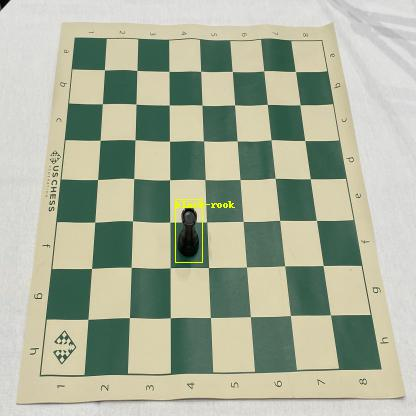

In [11]:
"""# Step 07. Test the results"""

# Check the trained weights

!ls checkpoints

# Choose random test image

import os
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);

print(img_path)

# Run test for a random image using a chosen checkpoints and visualization the result

!python models.py {num_classes} checkpoints/Yolov4_epoch25.pth {img_path} test/_classes.txt

from IPython.display import Image
Image('predictions.jpg')